### Kaggle Titanic Dataset to predict survived people

#### Import necessary libraries

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score,classification_report,confusion_matrix,plot_roc_curve
import warnings
from sklearn.preprocessing import StandardScaler
pd.set_option('display.max_columns', None)
warnings.filterwarnings('ignore')
%matplotlib inline

#### Import Data

In [3]:
train_df = pd.read_csv('train.csv')

test_df = pd.read_csv('test.csv')

sample_df = pd.read_csv('gender_submission.csv')

In [4]:
train_df['Source'] = 'train'

test_df['Source'] = 'test'

In [5]:
df = pd.concat([train_df, test_df])

#### Exploratory Data Analysis

In [6]:
df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Source
0,1,0.0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S,train
1,2,1.0,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C,train
2,3,1.0,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S,train
3,4,1.0,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S,train
4,5,0.0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S,train


In [7]:
df.reset_index(drop = True, inplace=True)

<AxesSubplot:>

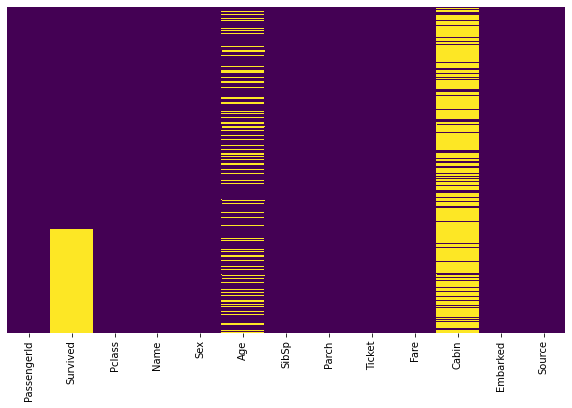

In [8]:
plt.figure(figsize=(10,6))
sns.heatmap(df.isnull(), yticklabels=False, cbar=False, cmap='viridis')

Cabin has more missing values, we can impute age null values by mean of pclass group

Let's continue to do more insights

<AxesSubplot:xlabel='Survived', ylabel='count'>

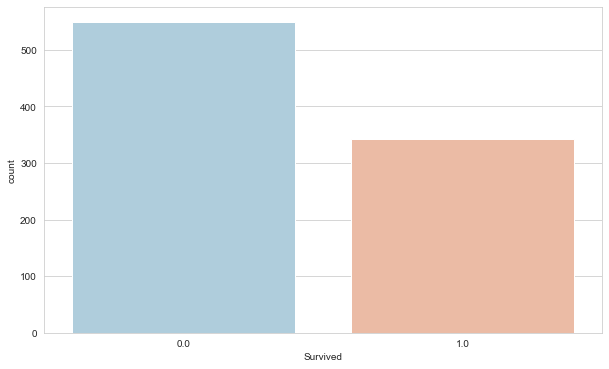

In [9]:
sns.set_style('whitegrid')
plt.figure(figsize=(10,6))
sns.countplot(x='Survived',data=df,palette='RdBu_r')
#looks like more people were not survived

<AxesSubplot:xlabel='Survived', ylabel='count'>

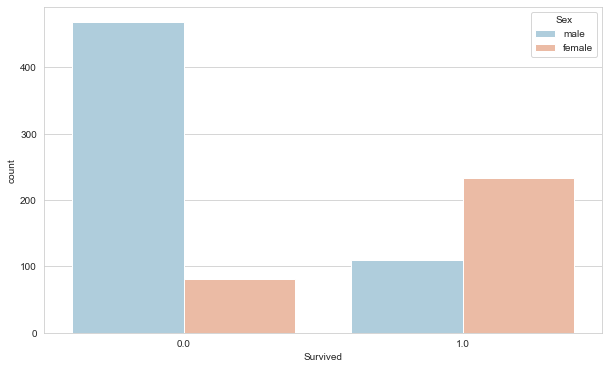

In [10]:
plt.figure(figsize=(10,6))
sns.countplot(x='Survived',hue='Sex',data=df,palette='RdBu_r')

More deaths are Male, whereas more survived people are female

<AxesSubplot:xlabel='Survived', ylabel='count'>

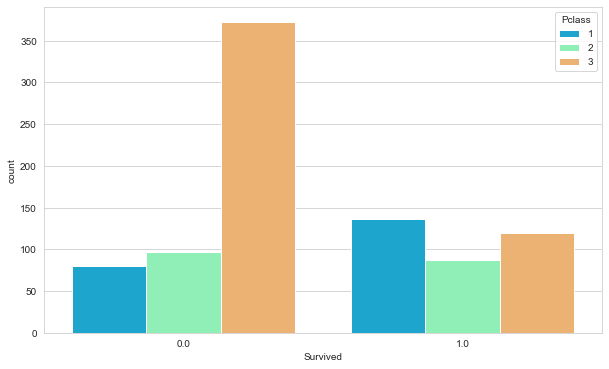

In [11]:
plt.figure(figsize=(10,6))
sns.countplot(x='Survived',hue='Pclass',data=df,palette='rainbow')

Most of the not survived people were travelled in 3rd class 

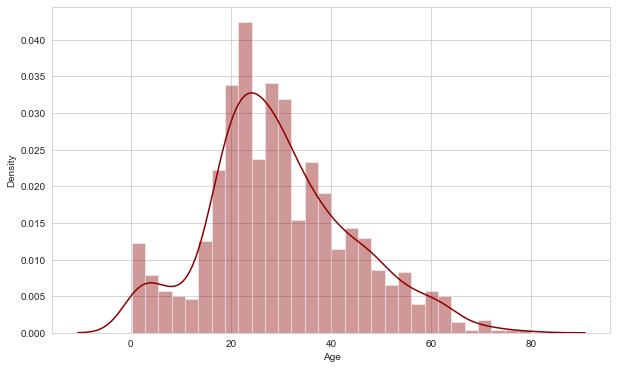

In [12]:
plt.figure(figsize=(10,6))
sns.distplot(df['Age'].dropna(),color='darkred',bins=30);

People's age is falling in the bin between 20-35, it follows a normal distribution

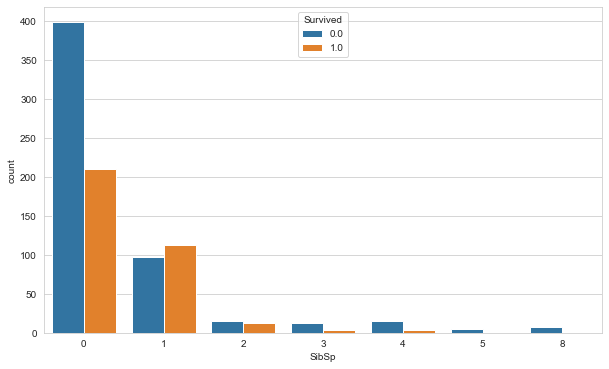

In [13]:
plt.figure(figsize=(10,6))
sns.countplot(x='SibSp',data=df, hue='Survived');

Sibsp - Number of Siblings/Spouses Aboard.
From the above count plot it clearly says most of the people who travelled have no Siblings/Spouses Abroad 

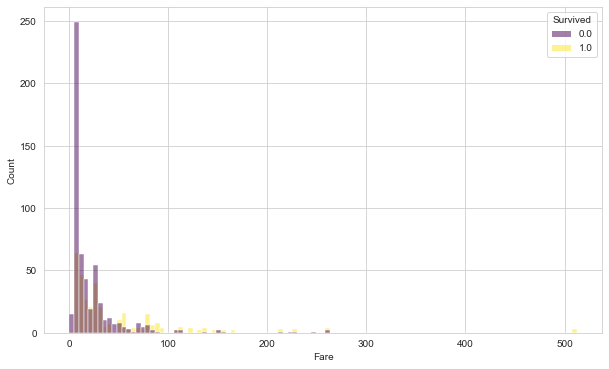

In [14]:
plt.figure(figsize=(10,6))
sns.histplot(x = 'Fare', data = df, hue='Survived', palette='viridis');

From the above graph we can say  most of the people who were not survived tralleved in a low ticket fare

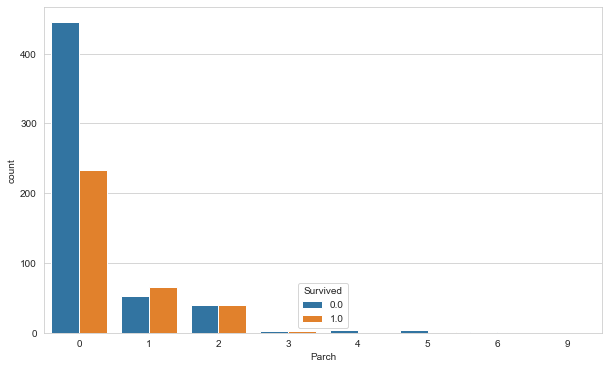

In [15]:
plt.figure(figsize=(10,6))
sns.countplot(x = 'Parch', data = df, hue ='Survived');

Parch - Number of Parents/Children Aboard.
People with no Parents/Children Aboard travelled in the titanic ship

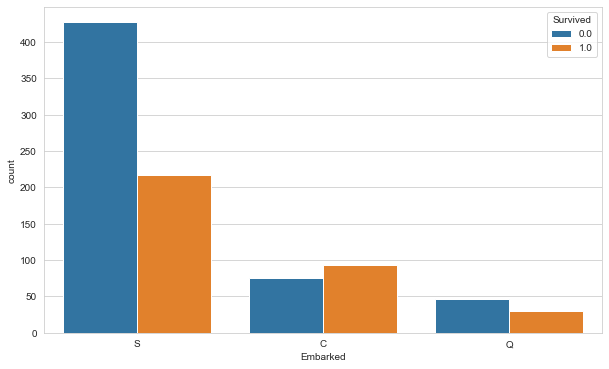

In [16]:
plt.figure(figsize=(10,6))
sns.countplot(x = 'Embarked', data=df, hue='Survived');

Embark — S-Southampton, C-Cherbourg, and Q-Queenstown
from the above graph we can the most people are embarked from Southampton

#### Data Cleaning

Instead of removing Age column, we can replace the null values in Age column by mean of Age w.r.t Passenger Class

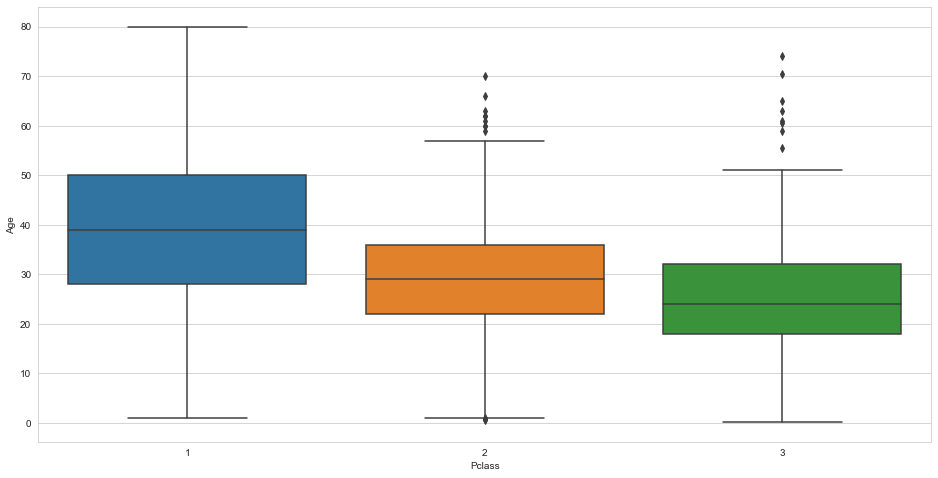

In [17]:
plt.figure(figsize=(16,8))
sns.boxplot(x='Pclass', y='Age' , data = df);

We can see the wealthier passengers in the higher classes tend to be older, which makes sense. We'll use these average age values to impute based on Pclass for Age.

#### Feature Engineering

In [18]:
#finding the mean age based on the class
df.groupby('Pclass')['Age'].mean()

Pclass
1    39.159930
2    29.506705
3    24.816367
Name: Age, dtype: float64

In [19]:
pclass_1 = 39
pclass_2 = 30
pclass_3 = 25

In [20]:
def impute_age(cols):
    Age = cols[0]
    Pclass = cols[1]
    
    if pd.isnull(Age):

        if Pclass == 1:
            return pclass_1

        elif Pclass == 2:
            return pclass_2

        else:
            return pclass_3

    else:
        return Age

In [21]:
df['Age'] = df[['Age','Pclass']].apply(impute_age,axis=1)

Let's see heatmap again

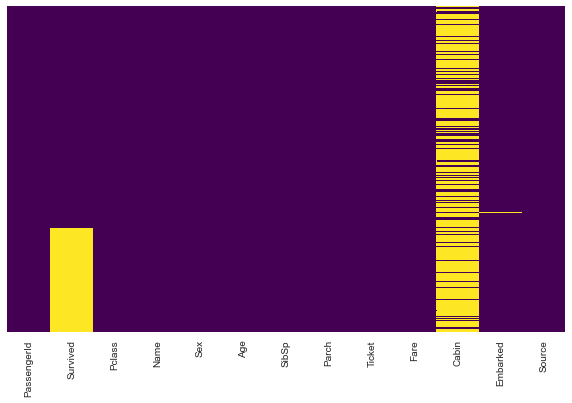

In [22]:
plt.figure(figsize=(10,6))
sns.heatmap(df.isnull(), yticklabels=False, cbar=False, cmap='viridis');

In [23]:
df['Cabin_1st'] = df['Cabin'].apply(lambda x : str(x)[0])

In [24]:
df['Embarked'].fillna(df['Embarked'].mode()[0], inplace= True)

In [26]:
#Fare column has null value in test data, we can't drop it, so I replaced with median value
df['Fare'].fillna(df.Fare.median(), inplace=True)

In [27]:
df['Relatives'] = df['SibSp'] + df ['Parch']

In [28]:
#to find insight in name columns
def split(i):
    pattern = ['Mr.', 'Mrs', 'Master', 'Miss', 'Rev', 'Don', 'Capt', 'Dr', 'Mme', 'Ms', 'Major', 'Col', 'Jonkheer', 'Mlle', 'Countess', 'Sir']
    for y in pattern:
        if y in i:
            return y
    else :
        return np.nan

In [31]:
df['Title'] = df['Name'].apply(split)

In [32]:
#reducing the cardinality
df['Title'] = df['Title'].replace('Ms', 'Miss').replace('Mme', 'Mrs').replace('Sir', 'Mr.').replace('Mr.','Mr').replace('Mlle','Mrs')

In [33]:
df['Title'].isna().sum()

0

In [34]:
#Taking ticket num into a new variable
def last_digit(i):
    return i.split()[-1]

In [35]:
df['Ticket_num'] = df['Ticket'].apply(last_digit)

In [36]:
#Don't think it as a error, just checking for presence of any other value
df['Ticket_num'].astype(int)

ValueError: invalid literal for int() with base 10: 'LINE'

#### Look's like ticket variable has String value, converting string value into the numerical values

In [37]:
for index,num in enumerate(df['Ticket_num']):
    if 'LINE' in num:
        df.iloc[index,-1] = '12345'
        
        print(index,num)

179 LINE
271 LINE
302 LINE
597 LINE


In [38]:
df['Ticket_num'] = df['Ticket_num'].astype(int)

#### Scaling 

In [39]:
sc = StandardScaler()

In [40]:
scaler = pd.DataFrame(sc.fit_transform(df[['Age', 'Ticket_num', 'Fare']]), columns= ['Age', 'Ticket_num', 'Fare'])

#### Encoding

In [41]:
#Encoding Sex , Embarked, Title and Passenger Class columns
sex = pd.get_dummies(data = df['Sex'], prefix='Sex', drop_first=True )

embarked = pd.get_dummies(data = df['Embarked'], prefix='Embark', drop_first=True)

pclass = pd.get_dummies(data = df['Pclass'], prefix='Pcls', drop_first=True)

title = pd.get_dummies(df['Title'], prefix='Tit', drop_first=True)

cabin = pd.get_dummies(df['Cabin_1st'], prefix='Cab', drop_first=True)

relative = pd.get_dummies(df['Relatives'], prefix='Rel', drop_first=True)

In [83]:
final_data = df.drop(['Age', 'Ticket_num', 'Fare', 'Sex', 'Embarked', 'Pclass', 'Title', 'Name', 'Relatives', 'PassengerId', 'Ticket', 'SibSp', 'Parch','Cabin', 'Cabin_1st'], axis = 1)

In [43]:
final_concat_data = pd.concat([final_data, scaler, sex, embarked, pclass, title, cabin, relative], axis = 1)

#### Spliting

In [44]:
final_train_data = final_concat_data[final_concat_data['Source'] == 'train']

final_test_data = final_concat_data[final_concat_data['Source'] == 'test']

In [45]:
X_train = final_train_data.drop(['Source', 'Survived'], axis = 1)

y_train = final_train_data['Survived']
y_train = y_train.astype(int) #Since it is float type

X_test = final_test_data.drop(['Source', 'Survived'], axis = 1)

#### Modelling

In [46]:
lg = LogisticRegression()

lg.fit(X_train, y_train)

LogisticRegression()

In [47]:
train_pred = lg.predict(X_train)

test_pred = lg.predict(X_test)

In [48]:
#Confusion Matrix
confusion_matrix(y_train, train_pred)

array([[486,  63],
       [ 76, 266]])

In [49]:
#Accuracy Score
accuracy_score(y_train, train_pred)

0.8439955106621774

In [50]:
y_train.sum()

342

In [51]:
print(classification_report(y_train, train_pred))

              precision    recall  f1-score   support

           0       0.86      0.89      0.87       549
           1       0.81      0.78      0.79       342

    accuracy                           0.84       891
   macro avg       0.84      0.83      0.83       891
weighted avg       0.84      0.84      0.84       891



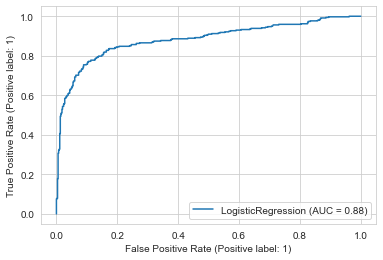

In [52]:
plot_roc_curve(lg, X_train, y_train)

In [110]:
sample_df['Survived'] = test_pred

sample_df.to_csv('Log Prediction.csv', index = False )

In [272]:
y_train.shape[0] - y_train.sum()

549

In [275]:
weight = y_train.shape[0]/(2 * 549)

In [276]:
weight

0.8114754098360656

In [287]:
lg = LogisticRegression(class_weight={1:0.6,0:0.811})

lg.fit(X_train, y_train)

LogisticRegression(class_weight={0: 0.811, 1: 0.6})

In [288]:
train_pred_1 = lg.predict(X_train)

test_pred_1 = lg.predict(X_test)

In [289]:
#Confusion Matrix
confusion_matrix(y_train, train_pred_1)

array([[506,  43],
       [ 99, 243]])

In [290]:
#Accuracy Score
accuracy_score(y_train, train_pred_1)

0.8406285072951739

In [291]:
print(classification_report(y_train, train_pred_1))

              precision    recall  f1-score   support

           0       0.84      0.92      0.88       549
           1       0.85      0.71      0.77       342

    accuracy                           0.84       891
   macro avg       0.84      0.82      0.83       891
weighted avg       0.84      0.84      0.84       891



In [292]:
sample_df['Survived'] = test_pred_1

sample_df.to_csv('Logist cls_wei Prediction_3.csv', index = False )

### Naive Bayes

In [134]:
from sklearn.naive_bayes import GaussianNB

In [135]:
nb = GaussianNB()

nb.fit(X_train, y_train)

GaussianNB()

In [149]:
train_pred_nb = nb.predict(X_train)

test_pred_nb = nb.predict(X_test)

In [150]:
confusion_matrix(y_train, train_pred_nb)

array([[ 39, 510],
       [  0, 342]])

In [140]:
accuracy_score(y_train, train_pred_nb)

0.4276094276094276

In [152]:
sample_df['Survived'] = test_pred_nb

sample_df.to_csv('Naive Prediction.csv', index = False )

#### K Nearest Neighbours

In [143]:
from sklearn.neighbors import KNeighborsClassifier

In [206]:
knn = KNeighborsClassifier(n_neighbors=13,n_jobs=-1)

In [207]:
knn.fit(X_train,y_train)

KNeighborsClassifier(n_jobs=-1, n_neighbors=13)

In [208]:
train_pred_knn = knn.predict(X_train)

In [209]:
confusion_matrix(y_train, train_pred_knn)

array([[507,  42],
       [101, 241]])

In [210]:
accuracy_score(y_train, train_pred_knn)

0.8395061728395061

In [211]:
test_pred_knn = knn.predict(X_test)

In [212]:
sample_df['Survived'] = test_pred_knn

sample_df.to_csv('KNN_13.csv', index = False )

In [175]:
error_rate = []

# Will take some time
for i in range(1,40):
    
    knn = KNeighborsClassifier(n_neighbors=i, n_jobs=-1)
    knn.fit(X_train,y_train)
    pred_i = knn.predict(X_test)
    error_rate.append(np.mean(pred_i != test_pred_knn))

Text(0, 0.5, 'Error Rate')

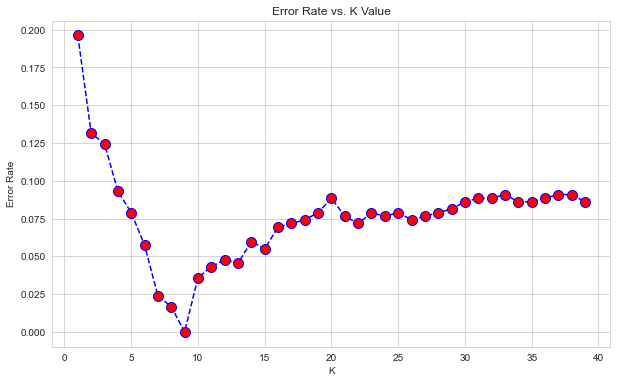

In [176]:
plt.figure(figsize=(10,6))
plt.plot(range(1,40),error_rate,color='blue', linestyle='dashed', marker='o',
         markerfacecolor='red', markersize=10)
plt.title('Error Rate vs. K Value')
plt.xlabel('K')
plt.ylabel('Error Rate')